In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#Defining path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/tumour_data/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/tumour_data/Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Creating a dataset using keras preprocessing with 80% train and 20% validation data**

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size = 32, subset="training", image_size=(180,180),validation_split=0.2, seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size = 32, subset="validation", image_size=(180,180),validation_split=0.2, seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
#print class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize Data**

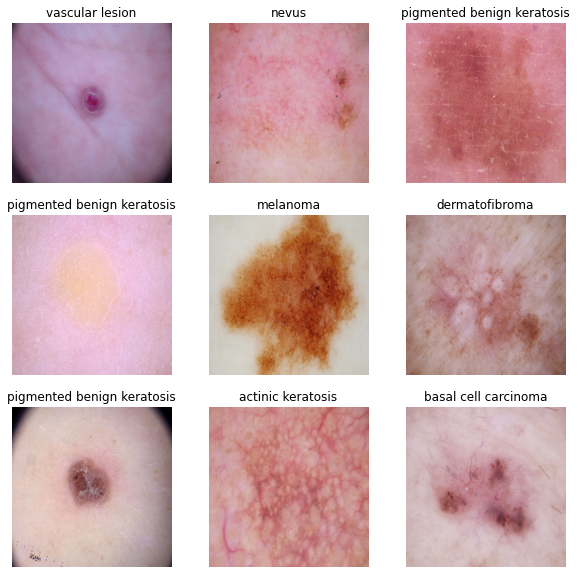

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
model_final = Sequential()
model_final.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model_final.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(180, 180, 3)))
model_final.add(MaxPool2D())

model_final.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_final.add(MaxPool2D())

model_final.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_final.add(MaxPool2D())

model_final.add(Flatten())
model_final.add(Dense(128))
model_final.add(Activation('relu'))

model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 16)     448       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 16)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 32)       4640      
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 32)       0         
 pper)                                                  

**Compile Model**

In [13]:
### Todo, choose an appropirate optimiser and loss function
model_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 16)     448       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 16)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 32)       4640      
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 32)       0         
 pper)                                                  

**Train Model**

In [15]:
epochs = 20
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 301s 1s/step - loss: 4.4919 - accuracy: 0.1468 - val_loss: 4.3306 - val_accuracy: 0.1991
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 4.3288 - accuracy: 0.1987 - val_loss: 4.2979 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 4.2493 - accuracy: 0.2059 - val_loss: 4.1853 - val_accuracy: 0.2170
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 4.2157 - accuracy: 0.2070 - val_loss: 4.1755 - val_accuracy: 0.2237
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 4.1894 - accuracy: 0.2109 - val_loss: 4.1474 - val_accuracy: 0.2237
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 4.1641 - accuracy: 0.2115 - val_loss: 4.1910 - val_accuracy: 0.2192
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 4.1564 - accuracy: 0.2126 - val_loss: 4.1521 - val_accuracy: 0.2215
Epoch 8/20
56

**Visualizing training results**

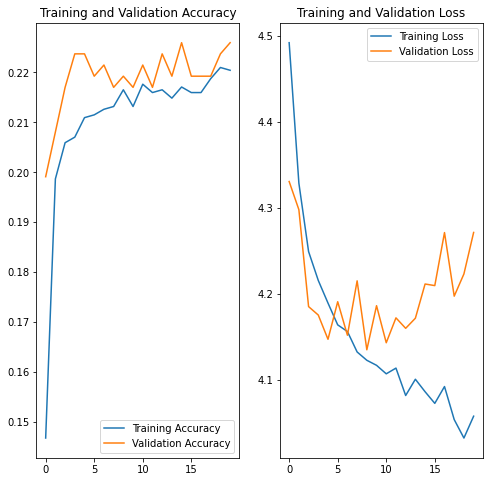

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**We can see that the validation loss is increasing when Training loss decreases, which means is a sign of overfitting**

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(180,180,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

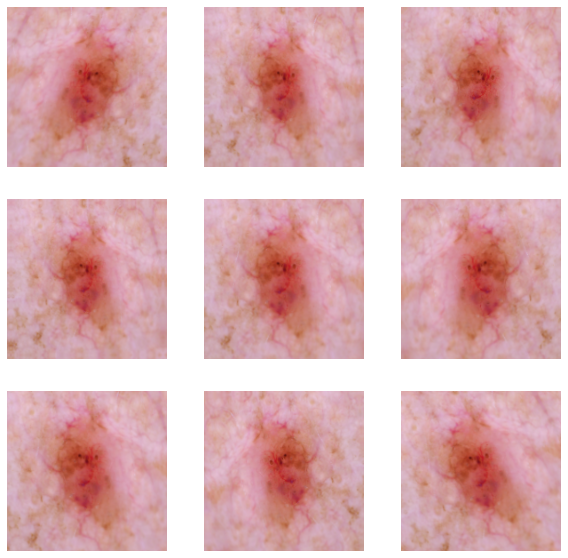

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Create the Model, Compile and Train**

In [19]:
#Using Dropout layer to avoid overfitting
model_final = Sequential()
model_final.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model_final.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(180, 180, 3)))
model_final.add(MaxPool2D())

model_final.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_final.add(MaxPool2D())

model_final.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_final.add(MaxPool2D())

model_final.add(Dropout(0.2))
model_final.add(Flatten())
model_final.add(Dense(128))
model_final.add(Activation('relu'))
model_final.add(Dense(9))

model_final.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_9 (ModuleWra  (None, 180, 180, 16)     448       
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_12 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

**Compiling the Model**

In [20]:
### Todo, choose an appropirate optimiser and loss function
model_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model_final.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_9 (ModuleWra  (None, 180, 180, 16)     448       
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_12 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

**Train the Model**

In [22]:
epochs = 20
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 28ms/step - loss: 1.8992 - accuracy: 0.2974 - val_loss: 1.6379 - val_accuracy: 0.4318
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.5346 - accuracy: 0.4531 - val_loss: 1.5376 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4802 - accuracy: 0.4671 - val_loss: 1.3868 - val_accuracy: 0.5503
Epoch 4/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3204 - accuracy: 0.5285 - val_loss: 1.3527 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3223 - accuracy: 0.5352 - val_loss: 1.4500 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2348 - accuracy: 0.5586 - val_loss: 1.3498 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.1448 - accuracy: 0.5904 - val_loss: 1.4240 - val_accuracy: 0.5280
Epoch 8/20
56

**Visualize the training results**

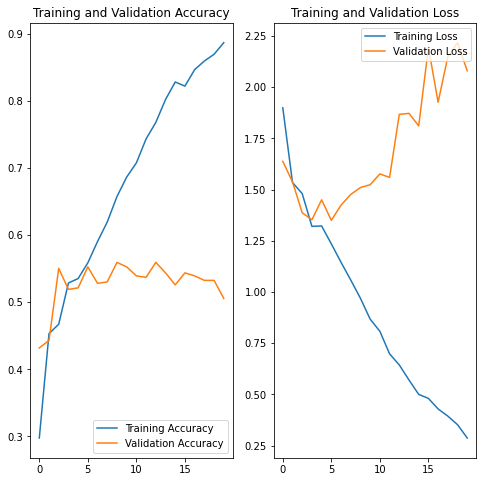

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:** Our Model Over fits as the training accuracy is high and validation accuracy is low.

Finding number of classes and distribution of classes in the training dataset to see if there is any imbalance/biased training data.

In [24]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/tumour_data/Train/squa...,squamous cell carcinoma
1,/content/gdrive/MyDrive/tumour_data/Train/squa...,squamous cell carcinoma
2,/content/gdrive/MyDrive/tumour_data/Train/squa...,squamous cell carcinoma
3,/content/gdrive/MyDrive/tumour_data/Train/squa...,squamous cell carcinoma
4,/content/gdrive/MyDrive/tumour_data/Train/squa...,squamous cell carcinoma
...,...,...
2234,/content/gdrive/MyDrive/tumour_data/Train/pigm...,pigmented benign keratosis
2235,/content/gdrive/MyDrive/tumour_data/Train/pigm...,pigmented benign keratosis
2236,/content/gdrive/MyDrive/tumour_data/Train/pigm...,pigmented benign keratosis
2237,/content/gdrive/MyDrive/tumour_data/Train/pigm...,pigmented benign keratosis


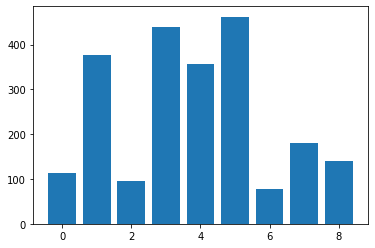

In [26]:
X, y = original_df['Path'], original_df['Label']
y = LabelEncoder().fit_transform(y)
count = Counter(y)
plt.bar(count.keys(), count.values())
plt.show()

Class Melanoma has highest number of samples with 400+ images and seborrheic keratosis has least number of samples around 50.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
path_to_training_dataset= "/content/gdrive/MyDrive/tumour_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6EF07B35B0>: 100%|██████████| 500/500 [00:19<00:00, 26.20 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6FD1B7E8B0>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6FD1B72D90>: 100%|██████████| 500/500 [00:19<00:00, 25.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6EF000F100>: 100%|██████████| 500/500 [01:36<00:00,  5.20 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6F6C1D59D0>: 100%|██████████| 500/500 [01:23<00:00,  6.01 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6EF0023A30>: 100%|██████████| 500/500 [00:19<00:00, 26.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6EF0657E80>: 100%|██████████| 500/500 [00:43<00:00, 11.37 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6EF0031880>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/tumour_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6EF0003250>: 100%|██████████| 500/500 [00:18<00:00, 26.82 Samples/s]


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/tumour_data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025350.jpg_d7516f58-efae-4d28-937e-4ec4b5e05098.jpg',
 '/content/gdrive/MyDrive/tumour_data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025539.jpg_703e74bd-7646-4d01-aafb-f9e5b1bcb798.jpg',
 '/content/gdrive/MyDrive/tumour_data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025069.jpg_8a7f215e-89cf-43f6-81a7-6c215ebe9b84.jpg',
 '/content/gdrive/MyDrive/tumour_data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_28af53a8-8b8a-4977-a8fa-ee449c00995e.jpg',
 '/content/gdrive/MyDrive/tumour_data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028231.jpg_64db9bfc-cbba-4802-999f-eeb36e97bb53.jpg',
 '/content/gdrive/MyDrive/tumour_data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025790.jpg_f73bb68b-8a5f-4448-b33f-f0bca588b5f

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [35]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [36]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [38]:
data_dir_train="/content/gdrive/MyDrive/tumour_data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=123,
validation_split = 0.2,
subset = 'training',
image_size=(img_height, img_width),
batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=123,
validation_split = 0.2,
subset = 'validation',
image_size=(img_height, img_width),
batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create your Model**

In [40]:
model_final = Sequential()
model_final.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model_final.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(180, 180, 3)))
model_final.add(MaxPool2D())

model_final.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_final.add(MaxPool2D())

model_final.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_final.add(MaxPool2D())

model_final.add(Dropout(0.2))
model_final.add(Flatten())
model_final.add(Dense(128))
model_final.add(Activation('relu'))
model_final.add(Dense(9))

model_final.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_20 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_21 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_22 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_23 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

**Compiling the Model**

In [41]:
### Todo, choose an appropirate optimiser and loss function
model_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train the Model**

In [42]:
epochs = 30
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 32s 179ms/step - loss: 1.9709 - accuracy: 0.2515 - val_loss: 1.6142 - val_accuracy: 0.3890
Epoch 2/30
169/169 [==============================] - 31s 180ms/step - loss: 1.4925 - accuracy: 0.4245 - val_loss: 1.4853 - val_accuracy: 0.4039
Epoch 3/30
169/169 [==============================] - 31s 177ms/step - loss: 1.3429 - accuracy: 0.4872 - val_loss: 1.2350 - val_accuracy: 0.5330
Epoch 4/30
169/169 [==============================] - 32s 184ms/step - loss: 1.1960 - accuracy: 0.5516 - val_loss: 1.1748 - val_accuracy: 0.5575
Epoch 5/30
169/169 [==============================] - 35s 201ms/step - loss: 1.0075 - accuracy: 0.6246 - val_loss: 1.0028 - val_accuracy: 0.6244
Epoch 6/30
169/169 [==============================] - 30s 173ms/step - loss: 0.8493 - accuracy: 0.6884 - val_loss: 0.8567 - val_accuracy: 0.6682
Epoch 7/30
169/169 [==============================] - 30s 173ms/step - loss: 0.7050 - accuracy: 0.7387 - val_loss: 0.8931 - val_ac

**Visualize the results**

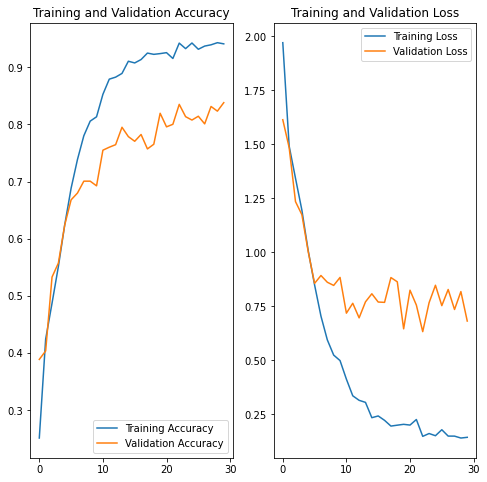

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Class Rebalance is helping to solve the problem of overfitting and is also reducing the validation loss with decrease in training loss.